## Pedicting Passenger Survival 

Given *data about passengers aboard the MS Estonia*, let's try to predict if a given passenger **survived** or not.

We will use three different models to make our predictions:

* Logistic Regression
* Support Vector Machine
* Neural network (2 hidden layers)

Data source: https://www.kaggle.com/datasets/christianlillelund/passenger-list-for-the-estonia-ferry-disaster

### Importing Libraries

In [23]:
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score

In [2]:
data = pd.read_csv('archive/estonia-passenger-list.csv')
data

,PassengerId,Country,Firstname,Lastname,Sex,Age,Category,Survived
0,1,Sweden,ARVID KALLE,AADLI,M,62,P,0
1,2,Estonia,LEA,AALISTE,F,22,C,0
2,3,Estonia,AIRI,AAVASTE,F,21,C,0
3,4,Sweden,JURI,AAVIK,M,53,C,0
4,5,Sweden,BRITTA ELISABET,AHLSTROM,F,55,P,0
...,...,...,...,...,...,...,...,...
984,985,Sweden,ANNA INGRID BIRGITTA,OSTROM,F,60,P,0
985,986,Sweden,ELMAR MIKAEL,OUN,M,34,P,1
986,987,Sweden,ENN,QUNAPUU,M,77,P,0
987,988,Sweden,LY,GUNAPUU,F,87,P,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  989 non-null    int64 
 1   Country      989 non-null    object
 2   Firstname    989 non-null    object
 3   Lastname     989 non-null    object
 4   Sex          989 non-null    object
 5   Age          989 non-null    int64 
 6   Category     989 non-null    object
 7   Survived     989 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 61.9+ KB


### Preprocessing

In [4]:
data.isna().sum()

PassengerId    0
Country        0
Firstname      0
Lastname       0
Sex            0
Age            0
Category       0
Survived       0
dtype: int64

In [5]:
data = data.drop('PassengerId', axis=1)

In [6]:
data

,Country,Firstname,Lastname,Sex,Age,Category,Survived
0,Sweden,ARVID KALLE,AADLI,M,62,P,0
1,Estonia,LEA,AALISTE,F,22,C,0
2,Estonia,AIRI,AAVASTE,F,21,C,0
3,Sweden,JURI,AAVIK,M,53,C,0
4,Sweden,BRITTA ELISABET,AHLSTROM,F,55,P,0
...,...,...,...,...,...,...,...
984,Sweden,ANNA INGRID BIRGITTA,OSTROM,F,60,P,0
985,Sweden,ELMAR MIKAEL,OUN,M,34,P,1
986,Sweden,ENN,QUNAPUU,M,77,P,0
987,Sweden,LY,GUNAPUU,F,87,P,0


In [7]:
data['Category'].unique()

array(['P', 'C'], dtype=object)

In [8]:
data['Country'].unique()

array(['Sweden', 'Estonia', 'Latvia', 'Russia', 'Germany', 'Finland',
       'Great Britain', 'Morocco', 'Denmark', 'France', 'Netherlands',
       'Norway', 'Lithuania', 'Nigeria', 'Canada', 'Belarus'],
      dtype=object)

In [10]:
data['Lastname'] = data['Lastname'].apply(lambda x: x[0])

In [11]:
data = data.drop('Firstname', axis=1)

In [12]:
data

,Country,Lastname,Sex,Age,Category,Survived
0,Sweden,A,M,62,P,0
1,Estonia,A,F,22,C,0
2,Estonia,A,F,21,C,0
3,Sweden,A,M,53,C,0
4,Sweden,A,F,55,P,0
...,...,...,...,...,...,...
984,Sweden,O,F,60,P,0
985,Sweden,O,M,34,P,1
986,Sweden,Q,M,77,P,0
987,Sweden,G,F,87,P,0


In [15]:
def binary_encode(df, column, positive_value):
    df = df.copy()
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df
    
def ordinal_encode(df, column, ordering):
    df = df.copy()
    df[column] = df[column].apply(lambda x: ordering.index(x))
    return df

def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], dtype=int)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [16]:
alphabet_ordering = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [17]:
# binary encoding
data = binary_encode(data, 'Sex', 'M')
data = binary_encode(data, 'Category', 'M')

# Ordinal encoding
data = ordinal_encode(data, 'Lastname', alphabet_ordering)

# One hot encoding
data = onehot_encode(data, 'Country')

In [18]:
data

,Lastname,Sex,Age,Category,Survived,Belarus,Canada,Denmark,Estonia,Finland,...,Germany,Great Britain,Latvia,Lithuania,Morocco,Netherlands,Nigeria,Norway,Russia,Sweden
0,0,1,62,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,22,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,21,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,53,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,55,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,14,0,60,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
985,14,1,34,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
986,16,1,77,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
987,6,0,87,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Splitting and Scaling

In [19]:
y = data['Survived']
X = data.drop('Survived', axis=1)

In [20]:
scaler = MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,Lastname,Sex,Age,Category,Belarus,Canada,Denmark,Estonia,Finland,France,Germany,Great Britain,Latvia,Lithuania,Morocco,Netherlands,Nigeria,Norway,Russia,Sweden
0,0.00,1.0,0.712644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.00,0.0,0.252874,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.0,0.241379,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,1.0,0.609195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.00,0.0,0.632184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,0.56,0.0,0.689655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
985,0.56,1.0,0.390805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
986,0.64,1.0,0.885057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
987,0.24,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

### Training

In [22]:
log_model = LogisticRegression()
svm_model = SVC(C=1.0)
ann_model = MLPClassifier(hidden_layer_sizes=(16, 16))

log_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
ann_model.fit(X_train, y_train)

/home/aditya/miniconda3/envs/tfenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,hidden_layer_sizes,"(16, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True
,random_state,None


In [24]:
log_acc = log_model.score(X_test, y_test)
svm_acc = svm_model.score(X_test, y_test)
ann_acc = ann_model.score(X_test, y_test)

log_preds = log_model.predict(X_test)
svm_preds = svm_model.predict(X_test)
ann_preds = ann_model.predict(X_test)

log_auc = roc_auc_score(y_test, log_preds)
svm_auc = roc_auc_score(y_test, svm_preds)
ann_auc = roc_auc_score(y_test, ann_preds)

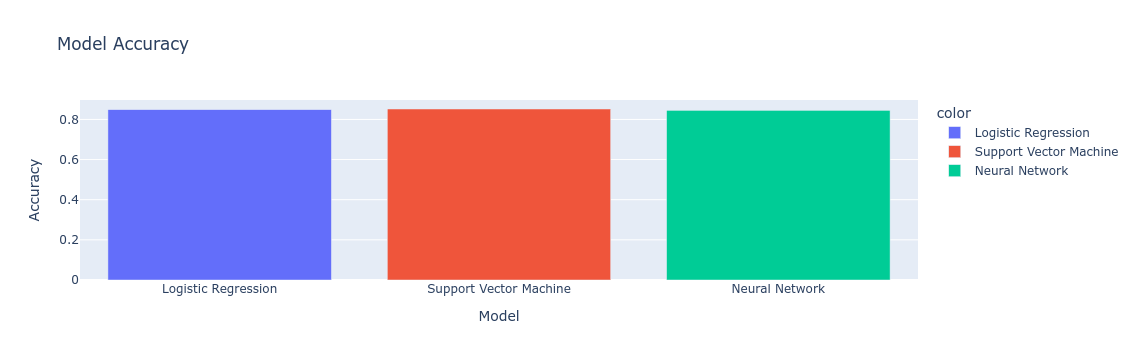

In [27]:
acc_fig = px.bar(
    x = ['Logistic Regression', 'Support Vector Machine', 'Neural Network'],
    y = [log_acc, svm_acc, ann_acc],
    labels = {'x': 'Model', 'y': 'Accuracy'},
    color = ['Logistic Regression', 'Support Vector Machine', 'Neural Network'],
    title = 'Model Accuracy'
)
acc_fig.show()

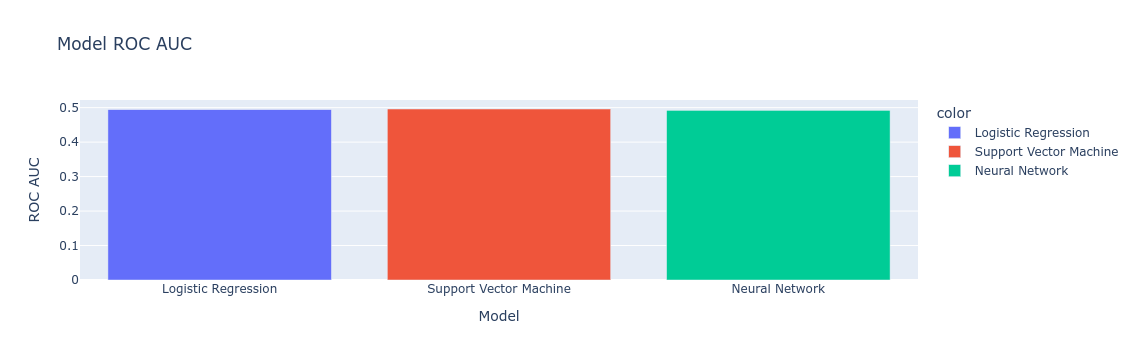

In [29]:
auc_fig = px.bar(
    x = ['Logistic Regression', 'Support Vector Machine', 'Neural Network'],
    y = [log_auc, svm_auc, ann_auc],
    labels = {'x': 'Model', 'y': 'ROC AUC'},
    color = ['Logistic Regression', 'Support Vector Machine', 'Neural Network'],
    title = 'Model ROC AUC'
)
auc_fig.show()

In [32]:
1 - y.sum() / len(y) # baseline accuracy

np.float64(0.8614762386248735)